# План домашних заданий


- Описание задачи и знакомство с данными
- Домашнее задание 1. Генерация и фильтрация признаков
- Домашнее задание 2. Прогноз времени и вида поломки машин, настройка ML-модели
- Дополнительное задание. Визуализация прогнозов, ошибок модели и важности признаков
- Домашнее задание 3. Оптимизация. Тюнинг гиперпараметров с помощью `Optuna`
- Домашнее задание 4. Блендинг
- Домашнее задание 5. Парсинг внешних данных и оптимизация памяти
- Отправка финального решения на лидерборд на Kaggle

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# <center id="part0"> Описание задачи

**Предыстория:**  мы работаем с каршеринговой компанией, которая управляет крупным автопарком машин. Наша цель — предотвратить длительные периоды простоя машин из-за поломок через своевременное обслуживание и ремонт.


**Идея для решения проблемы:** создать приоритизированный список обхода машин. Этот список поможет технической бригаде сосредоточиться на автомобилях, которые наиболее вероятно выйдут из строя в ближайшее время.


**Как компания решает задачу:**

* Собирает данные о поездках и состоянии машин до поломок.

* Нанимает Data Scientist, чтобы он смог использовать эти данные для анализа и прогнозирования характера поломок.

**Важный момент**: задачи этого специалиста (Data Scientist) предстоит выполнять вам.

## <center> Знакомство с данными

### Информация про машины с таргетом (основной датасет)

In [2]:
car_train = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_train.csv')
car_train.sample(5)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class
349,I17502941F,VW Polo VI,economy,petrol,3.22,2012,26520,2014,61.71,another_bug
1231,Z21101596H,Kia Rio X-line,economy,petrol,4.44,2013,47809,2018,38.16,electro_bug
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,38.62,gear_stick
264,s22685968d,Skoda Rapid,economy,petrol,3.62,2014,61312,2018,33.76,electro_bug
2067,h-2930740k,Audi A4,premium,petrol,4.72,2017,116983,2017,45.76,engine_overheat


- `car_id` — идентификатор машины
- `model` / `car_type` / `fuel_type` — марка, класс и тип топлива машины
- `car_rating` / `riders` — общий рейтинг и общее число поездок к концу 2021 года
- `year_to_start` / `year_to_work` — год выпуска машины и год начала работы в автопарке
- `target_reg` — количество дней до поломки
- `target_class` — класс поломки (всего 9 видов)

### Информация про поездки

In [3]:
rides_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/rides_info.csv')
rides_info.sample(5)

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal
390026,R80652510K,b14467388K,l1m,2020-02-18,0.72,17,232,44,76.0,1,770.984207,0,-7.332972,-0.001
728240,m10040831G,z-3485115T,c1Q,2020-01-27,2.88,19,202,40,67.0,1,443.590506,0,0.966542,-0.000
673062,i15585169z,v-7924266I,V1s,2020-01-17,3.98,70,554,51,56.0,1,2598.781791,0,5.334000,0.000
420467,T55107179j,d19132071d,O1O,2020-02-13,5.67,2,9,52,119.0,0,139.981132,0,11.803069,-30.179
262884,p13102671b,S-4820484y,i1t,2020-03-17,4.51,24,187,34,74.0,1,443.314724,0,-3.809343,-65.251


- `user_id` / `car_id` / `ride_id` — идентификаторы водителя, машины, поездки соответственно
- `ride_date` / `rating` — дата поездки и рейтинг, поставленный водителем
- `ride_duration` / `distance` / `ride_cost` —  длительность (время),  пройденное расстояние, стоимость поездки
- `speed_avg` / `speed_max` — средняя и максимальная скорости поездки соответственно
- `stop_times` / `refueling` — количество остановок (паузы) и флаг: была ли дозаправка
- `user_ride_quality` — оценка манеры вождения водителя машины, определенная скоринговой ML-системой сервиса
- `deviation_normal` — общий показатель датчиков о состоянии машины, относительно эталонных показателей (нормы)

### Информация про водителей

In [4]:
driver_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/driver_info.csv')
driver_info.sample(5)

,age,user_rating,user_rides,user_time_accident,user_id,sex,first_ride_date
14599,37,8.9,40,6.0,a17923405S,0,2019-11-25
12870,23,7.2,485,23.0,r15688731W,1,2020-6-18
10668,47,7.0,67,7.0,q51560549d,0,2020-2-28
14456,35,7.5,2253,6.0,V13434735A,0,2021-12-24
6383,47,8.3,880,2.0,H38121300M,0,2019-3-25


- `user_id` / `age` / `sex` — идентификатор, возраст и пол водителя, соответственно
- `user_rating` — общий рейтинг пользователя за все поездки к концу 2021 года
- `user_rides` — общее количество поездок к концу 2021 года
- `user_time_accident` — число инцидентов (это могли быть аварии/штрафы/эвакуация машины)  
- `first_ride_date` — дата первой поездки

### Информация про ремонт машин

In [5]:
fix_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/fix_info.csv')
fix_info.sample(5)

,car_id,worker_id,fix_date,work_type,destroy_degree,work_duration
141544,g-1760425A,NK,2020-8-20 22:38,repair,4.9,12
121518,Q11656086H,XD,2021-10-28 10:47,reparking,1.0,27
2017,C-1335407d,VZ,2020-5-2 20:1,reparking,1.0,27
127725,v11532085a,JP,2019-1-2 5:44,reparking,1.0,23
32589,r10507876y,GO,2021-6-16 20:40,repair,5.1,12


- `worker_id` / `car_id` — идентификатор работника и машины
- `work_type` / `work_duration` — тип и длительность (в часах) проводимой работы
- `destroy_degree` — степень износа/поврежденности машины в случае поломки
- `fix_date` — время начала ремонта (снятия машины с линии)

# Домашнее задание 1. Генерация и фильтрация признаков

<center> <img src="https://ucarecdn.com/bf4c772d-b67a-42ae-a48b-cfd83910b0a2/" width=700>

<div class="alert alert-info">

**Цель блока** — сгенерировать признаки из дополнительных датасетов и добавить их к основному датасету, произвести фильтрацию признаков.

    
## Задание 1. Генерация признаков из дополнительных датасетов (6 баллов)

<div class="alert alert-info">

1. Возьмите датасет `rides_info` с информацией о поездках и проведите группировку по каждой машине отдельно.

2. Для каждой машины (то есть для каждого `car_id`) подсчитайте несколько признаков:
  - минимальный рейтинг за все поездки;
  - средний рейтинг за все поездки;
  - общее количество километров, которое машина проехала;
  - максимальная скорость;
  - общее количество поездок для каждой машины.

3. Добавьте минимум 3 признака на свой выбор.

4. Сделайте соединение таблиц — вспомните про методы соединения и выберите подходящий для этого случая.

5. Подключите информацию про водителей (`driver_info`) и про ремонт машин (`fix_info`). Добавьте минимум 3 любых признака с каждого датасета.


<h4> Критерии оценивания </h4>
    
- Добавлены 5 обязательных и минимум 3 любых признака из датасета `rides_info` — 2 балла.
- Добавлены минимум 3 любых признака из датасета `driver_info` — 2 балла.
- Добавлены минимум 3 любых признака из датасета `fix_info` — 2 балла.

</div>

<div class="alert alert-success">
    
<h4> Советы по Feature Engineering</h4>
    
- Начинайте с сырых данных.
- Используйте все доступные данные. Покрывайте признаками всю имеющуюся информацию в данных.
- Формулируйте предположения: от чего зависит таргет?
- Смотрите визуально на классы/ошибки и делайте предположения. Какие полезны?
- Помните, что слишком много признаков может быть вредно. Потом придется отфильтровывать.
    
<h4> Полезные источники </h4>
    
- Занятие про Feature Engineering.
- Занятие про Feature Selection.
- [Max Kuhn and Kjell Johnson. Feature Engineering and Selection: A Practical Approach for Predictive Models](http://www.feat.engineering/).

### Пример расчета признака

In [6]:
# Пример расчета одного признака
rides_features = rides_info.groupby('car_id', as_index=False).agg(
    min_rating=('rating', 'min'),
    mean_rating=('rating', 'mean'),
    total_distance=('distance', 'sum'),
    max_speed=('speed_max', 'max'),
    total_rides=('ride_id', 'count'),
    mean_ride_duration=('ride_duration', 'mean'),
    mean_speed_avg=('speed_avg', 'mean'),
    total_refueling=('refueling', 'sum')
)

df = pd.merge(car_train, rides_features, on='car_id', how='left') # Соедините полученный датасет с фичами с основным датасетом

df.head()

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,min_rating,mean_rating,total_distance,max_speed,total_rides,mean_ride_duration,mean_speed_avg,total_refueling
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,0.1,4.737759,1.214131e+07,180.855726,174,1635.770115,44.660920,0
1,O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,35.20,electro_bug,0.0,4.480517,1.803909e+07,187.862734,174,2223.178161,49.862069,0
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,38.62,gear_stick,0.1,4.768391,1.588366e+07,102.382857,174,2048.856322,44.005747,0
3,u29695600e,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,30.34,engine_fuel,0.1,3.880920,1.651883e+07,172.793237,174,1943.511494,49.344828,0
4,N-8915870N,Renault Sandero,standart,petrol,4.70,2012,26428,2017,30.45,engine_fuel,0.1,4.181149,1.398317e+07,203.462289,174,1597.793103,50.603448,0


In [8]:
# Агрегация признаков из driver_info
driver_features = driver_info.groupby('user_id', as_index=False).agg(
    mean_user_rating=('user_rating', 'mean'),
    total_user_rides=('user_rides', 'sum'),
    total_user_accidents=('user_time_accident', 'sum')
)

In [9]:
# Агрегация признаков из fix_info
fix_features = fix_info.groupby('car_id', as_index=False).agg(
    mean_destroy_degree=('destroy_degree', 'mean'),
    total_work_duration=('work_duration', 'sum'),
    unique_workers=('worker_id', 'nunique')
)

In [10]:
df = pd.merge(df, driver_features, left_on='car_id', right_on='user_id', how='left')
df = pd.merge(df, fix_features, on='car_id', how='left')

df.head()

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,...,mean_ride_duration,mean_speed_avg,total_refueling,user_id,mean_user_rating,total_user_rides,total_user_accidents,mean_destroy_degree,total_work_duration,unique_workers
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,1635.770115,44.660920,0,NaN,NaN,NaN,NaN,3.048571,933,33
1,O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,35.20,electro_bug,...,2223.178161,49.862069,0,NaN,NaN,NaN,NaN,2.917143,873,34
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,38.62,gear_stick,...,2048.856322,44.005747,0,NaN,NaN,NaN,NaN,3.740000,915,35
3,u29695600e,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,30.34,engine_fuel,...,1943.511494,49.344828,0,NaN,NaN,NaN,NaN,4.085714,1007,34
4,N-8915870N,Renault Sandero,standart,petrol,4.70,2012,26428,2017,30.45,engine_fuel,...,1597.793103,50.603448,0,NaN,NaN,NaN,NaN,3.880000,981,34


### Идеи для новых признаков

1.   Новый пункт
2.   Новый пункт



* `feature_min_max_diff` — разница между максимальным и минимальным значениями `deviation_normal` для каждой машины
* `feature_corner` — угол наклона по признаку `user_ride_quality` для каждой машины
* `feature_mean` — среднее значение `deviation_normal` для каждой машины
* `feature_shift` — точка перегиба/сдвига для `deviation_normal`
* `feature_start` — значение точки старта для `deviation_normal`
* `feature_nans` — сумма пропусков для столбца `...` для каждой машины
* `feature_quant` — `X %` квантиль для столбца `...` для каждой машины

Подумайте, какие из признаков могут оказаться самыми полезными?

Я выбрал 3 дополнитеьлных признака:<br>

- `feature_min_max_diff` (разница между максимальным и минимальным значениями deviation_normal для каждой машины) может быть полезным, так как большая разница указывает на нестабильность состояния машины, что может быть предиктором поломок.

- `feature_mean` (среднее значение deviation_normal для каждой машины) даст понимание общего состояния машины по сравнению с нормой, что может помочь выявить машины с потенциальными проблемами.

- `feature_quant` (X % квантиль для столбца ... для каждой машины) может быть полезным для идентификации экстремальных значений, которые могут указывать на редкие, но серьезные проблемы.

In [11]:
rides_features_additional = rides_info.groupby('car_id', as_index=False).agg(
    feature_min_max_diff=('deviation_normal', lambda x: x.max() - x.min()),
    feature_mean_deviation_normal=('deviation_normal', 'mean'),
    feature_75_quant_deviation_normal=('deviation_normal', lambda x: x.quantile(0.75))
)

In [12]:
df = pd.merge(df, rides_features_additional, on='car_id', how='left')
df.head()

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,...,user_id,mean_user_rating,total_user_rides,total_user_accidents,mean_destroy_degree,total_work_duration,unique_workers,feature_min_max_diff,feature_mean_deviation_normal,feature_75_quant_deviation_normal
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,NaN,NaN,NaN,NaN,3.048571,933,33,9.001,-0.120391,0.00100
1,O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,35.20,electro_bug,...,NaN,NaN,NaN,NaN,2.917143,873,34,72.761,6.050011,16.69100
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,38.62,gear_stick,...,NaN,NaN,NaN,NaN,3.740000,915,35,16.401,-2.223954,0.00000
3,u29695600e,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,30.34,engine_fuel,...,NaN,NaN,NaN,NaN,4.085714,1007,34,61.647,14.771948,28.18550
4,N-8915870N,Renault Sandero,standart,petrol,4.70,2012,26428,2017,30.45,engine_fuel,...,NaN,NaN,NaN,NaN,3.880000,981,34,70.176,12.455678,30.65725


## Задание 2. Применение методов фильтрации признаков (4 балла)

<center> <img src="https://ucarecdn.com/d1b4bc78-fd04-44fb-bdbf-0a63355b7384/" width=700>

1. Выберите и примените любые 3 (можно и больше) метода фильтрации, которые указаны выше или в ноутбуке по фильтрации из полезных ссылок.
2. Проинтерпретируйте результаты и сделайте выводы.


<h4> Критерии оценивания </h4>
    
- Применены методы фильтрации — 1 балл за каждый метод, максимум 3 балла.
- Сделаны выводы на основе примененных методов —1 балл.
</div>

### Советы по Feature Selection

<div class="alert alert-info">

<h3><center>Зачем отбирать признаки</center></h3>
    
**Основные причины**:
    
- Главная причина: с увеличением количества признаков часто падает точность предсказания модели, а некоторые модели и вовсе перестают адекватно работать. Так происходит, если в данных большое количество мусорных фичей (почти не коррелирующих с таргетом).

- Если фичей очень много, то данные перестают помещаться в память и существенно увеличивают время обучения модели, особенно если мы тестируем несколько алгоритмов или ансамбль. Также важно учитывать, что платформы имеют ограничения на длительность одной сессии (в Kaggle — 12 часов) и лимиты по потребляемой памяти.

- Даже если точность не снижается, есть риск, что модель опирается на шумные фичи, что снизит стабильность прогноза на приватной выборке.


<b>Что удалить сразу:</b>
    
- константы;
- уникальные значения (в том числе в тесте; как правило, это ID-шники по типу `car_id`).
    
<b>Какие методы использовать:</b>
    
- `Линейная корреляция`.
- `Phik` — тоже корреляция, но на стероидах ([туториал на Medium](https://towardsdatascience.com/phik-k-get-familiar-with-the-latest-correlation-coefficient-9ba0032b37e7)).
- `Permutation importance` (из `scikit-learn`).
- `SHAP values` (из библиотеки `shap`).
- `CatBoost Feature Selection` (рекурсивные методы).
    

In [13]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.inspection import permutation_importance
import shap
import phik
from phik import resources, report

C:\Users\Admin108\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
# Удаление констант и уникальных значений

df = df.loc[:, (df.nunique() > 1) & (df.nunique() != len(df))]

In [15]:
# числовые столцы для анализа корреляции
numeric_features = df.select_dtypes(include=['float64', 'int64'])

# корреляци пирсона числовыи признакоыв и target_reg
correlation_with_target = numeric_features.corrwith(df['target_reg']).sort_values()

In [16]:
correlation_with_target

mean_destroy_degree                 -0.441411
total_work_duration                 -0.123805
mean_speed_avg                      -0.112508
mean_ride_duration                  -0.036293
mean_rating                         -0.017549
unique_workers                      -0.005835
riders                               0.003259
year_to_start                        0.006390
total_refueling                      0.011362
feature_min_max_diff                 0.015546
car_rating                           0.024515
year_to_work                         0.034604
min_rating                           0.038629
feature_75_quant_deviation_normal    0.085651
feature_mean_deviation_normal        0.134768
max_speed                            0.420563
target_reg                           1.000000
dtype: float64

In [17]:
X = df.drop(['target_class', 'target_reg'], axis=1)
X = pd.get_dummies(X, drop_first=True)
y = df['target_class']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
model = CatBoostClassifier(random_seed=42, verbose=0)
model.fit(X_train, y_train)

In [20]:
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

In [21]:
feature_importances = pd.DataFrame(perm_importance.importances_mean, index=X.columns, columns=['Importance']).sort_values(by='Importance', ascending=False)

In [22]:
feature_importances.head(10)

,Importance
max_speed,0.414103
mean_speed_avg,0.177350
mean_rating,0.175000
min_rating,0.129915
mean_destroy_degree,0.112393
feature_mean_deviation_normal,0.027991
feature_min_max_diff,0.009615
total_work_duration,0.007479
feature_75_quant_deviation_normal,0.007479
car_rating,0.004915


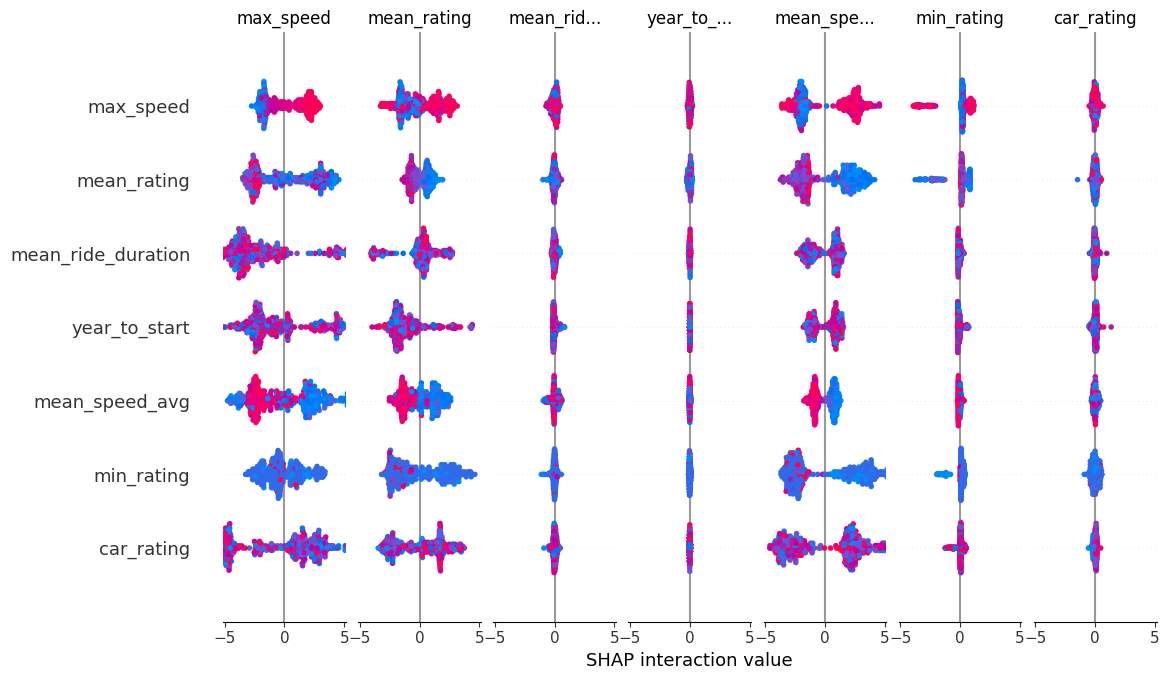

In [23]:
# test SHAP

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Визуализация SHAP значений
shap.summary_plot(shap_values, X_test)

In [24]:
# test Phik

phik_overview = df.phik_matrix()

interval columns not set, guessing: ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'target_reg', 'min_rating', 'mean_rating', 'max_speed', 'mean_ride_duration', 'mean_speed_avg', 'total_refueling', 'mean_destroy_degree', 'total_work_duration', 'unique_workers', 'feature_min_max_diff', 'feature_mean_deviation_normal', 'feature_75_quant_deviation_normal']


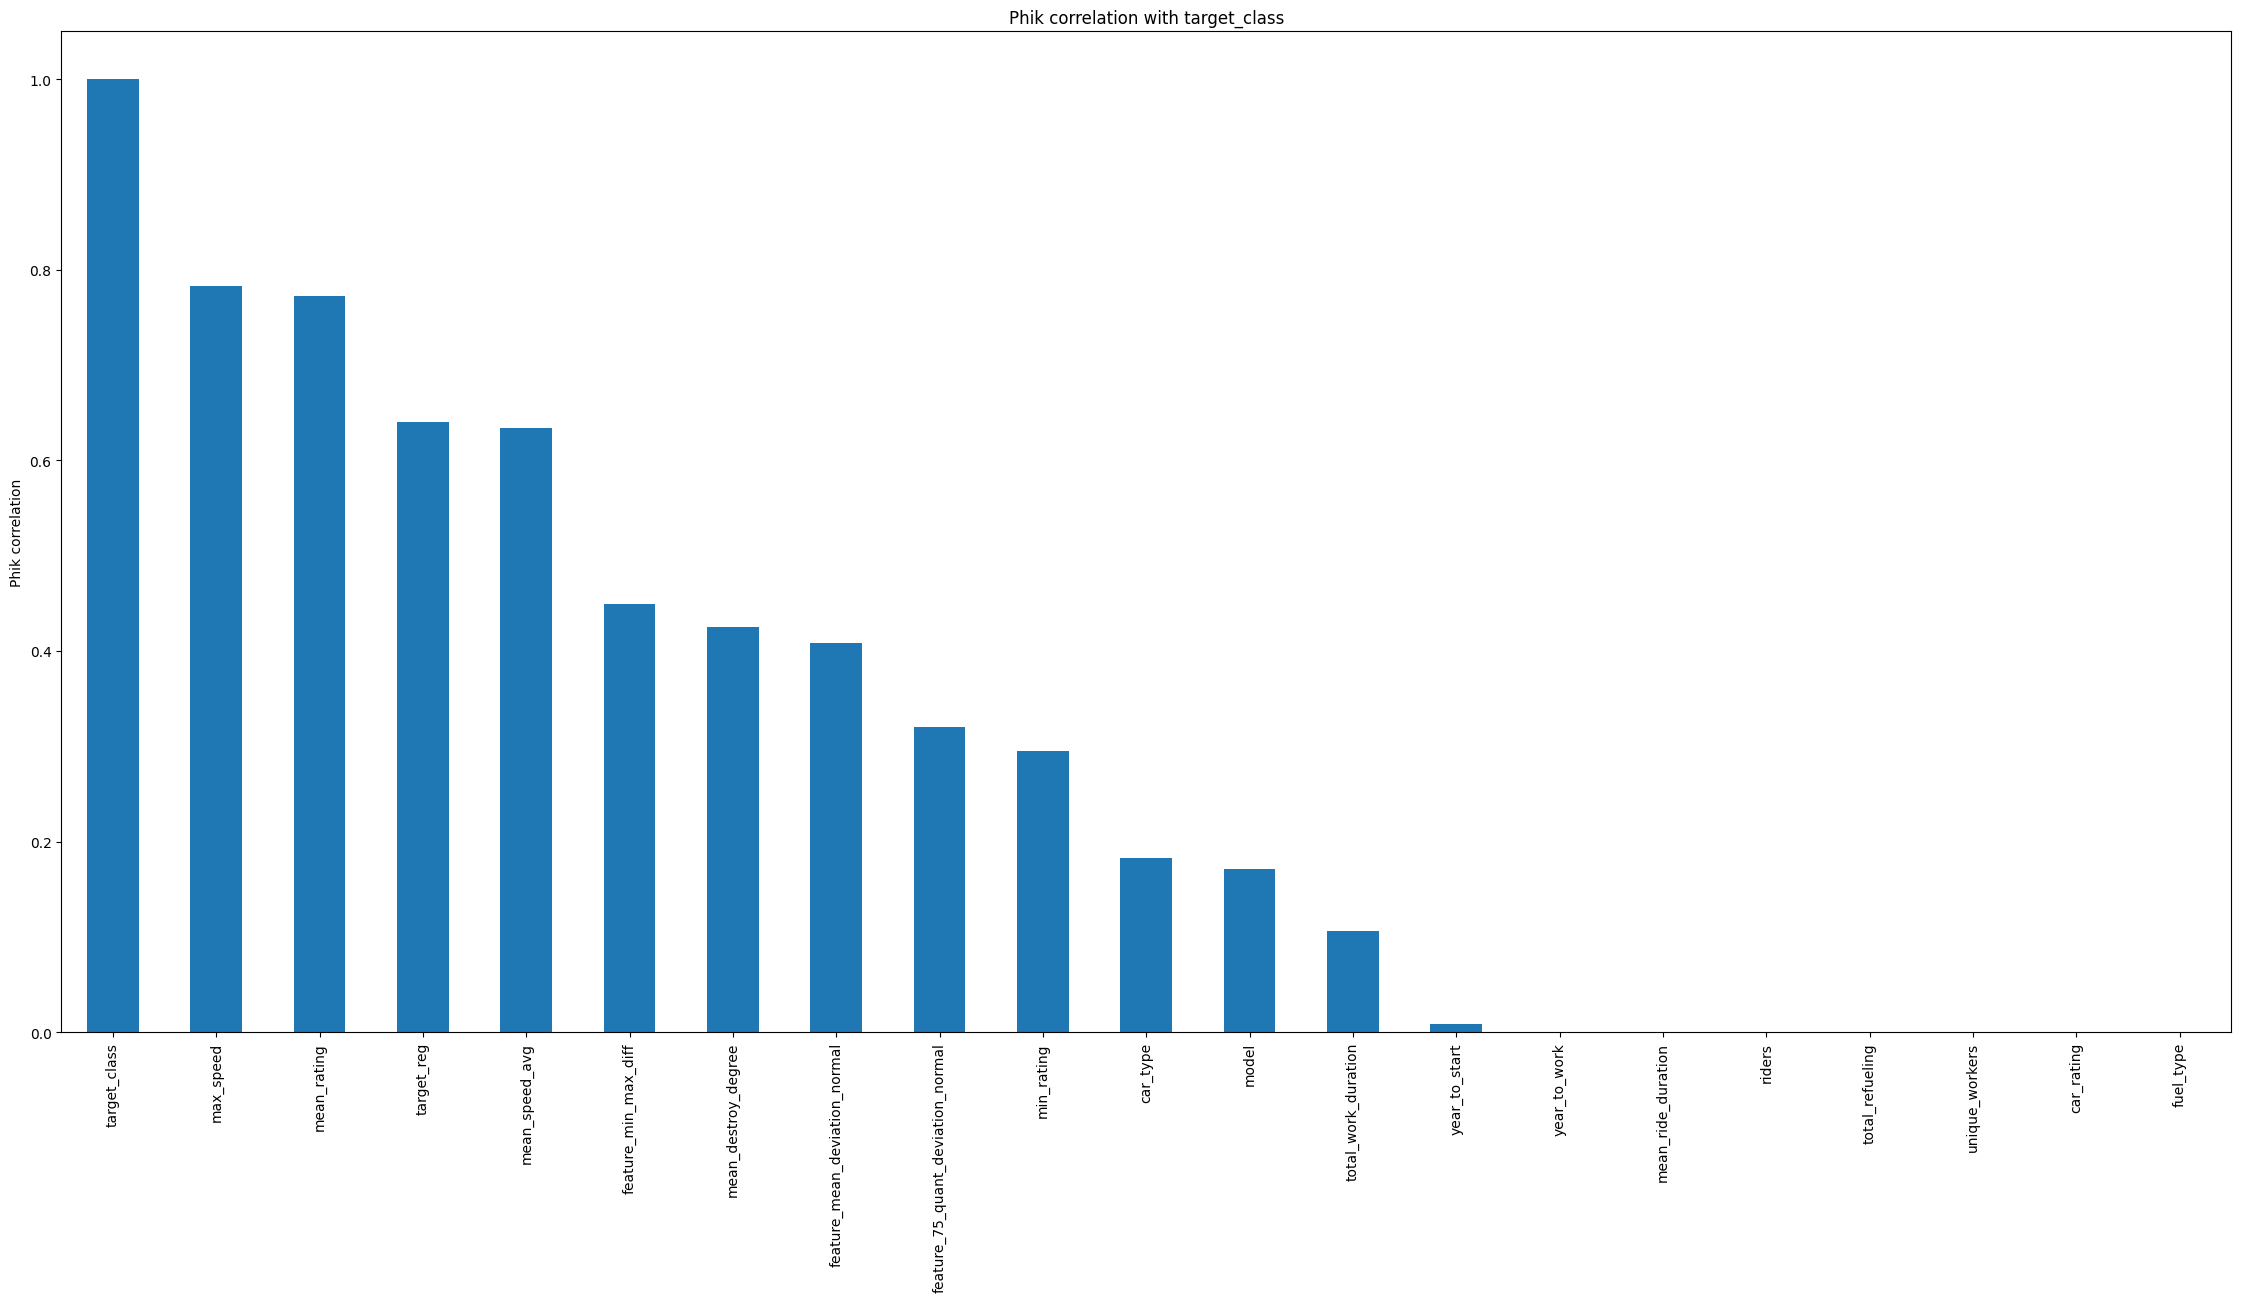

In [25]:
plt.figure(figsize=(28, 13))
phik_overview_heatmap = phik_overview['target_class'].sort_values(ascending=False).plot(kind='bar')
plt.title('Phik correlation with target_class')
plt.ylabel('Phik correlation')
plt.show()

# Выводы

`max_speed`: самое сильное влияние на предсказанияч. Высокме значения признака, имеют прямую влияение на целевую переменную

`mean_rating` и `mean_ride_duration`: также оказывают заметное влияние на модель. Вариации mean_rating могут как увеличивать, так и уменьшать предсказанное значение, в то время как mean_ride_duration влияет в положительную сторону.

`year_to_start`, `mean_speed_avg`, `min_rating`, и `car_rating`: влияние присутствует, но не так выражено, как у `max_speed`. Кроме того, распределение на графике SHAP относительно нулевой линии указывает на вариативностб влияния в зависимости от конкретного значения признака.

# Домашнее задание 2. Прогноз времени и вида поломки машин. Настройка ML-модели

<div class="alert alert-info">

**Цель блока** — составить тренировочную и валидационную выборки, произвести обучение модели `CatBoostClassifier` на тренировочной части и оценить качество на валидационной.

##Обучение первой модели (5 баллов)

1.   Новый пункт
2.   Новый пункт



1. Классифицируйте признаки на типы (категориальные, числовые, таргеты).

2. Выделите в `X` только признаки, а в `Y` — таргет (для задачи классификации).

3. Сделайте разделение данных на *обучающую* и *валидационную* выборки (не забывайте про воспроизводимость результатов).

4. Создайте и обучите `CatBoostClassifier` модель (настраивать гиперпараметры сейчас не обязательно).

5. Проведите оценку вашей модели, используя метрику `accuracy`.


<h4> Критерии оценивания </h4>
    
- По 1 баллу за каждый корректно выполненный пункт.

</div>

In [46]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier

In [47]:
df = pd.read_csv('df.csv')

In [48]:
df

,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,min_rating,...,max_speed,mean_ride_duration,mean_speed_avg,total_refueling,mean_destroy_degree,total_work_duration,unique_workers,feature_min_max_diff,feature_mean_deviation_normal,feature_75_quant_deviation_normal
0,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,0.10,...,180.855726,1635.770115,44.660920,0,3.048571,933,33,9.001,-0.120391,0.00100
1,VW Polo VI,economy,petrol,3.90,2015,78218,2021,35.20,electro_bug,0.00,...,187.862734,2223.178161,49.862069,0,2.917143,873,34,72.761,6.050011,16.69100
2,Renault Sandero,standart,petrol,6.30,2012,23340,2017,38.62,gear_stick,0.10,...,102.382857,2048.856322,44.005747,0,3.740000,915,35,16.401,-2.223954,0.00000
3,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,30.34,engine_fuel,0.10,...,172.793237,1943.511494,49.344828,0,4.085714,1007,34,61.647,14.771948,28.18550
4,Renault Sandero,standart,petrol,4.70,2012,26428,2017,30.45,engine_fuel,0.10,...,203.462289,1597.793103,50.603448,0,3.880000,981,34,70.176,12.455678,30.65725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2332,Smart ForFour,economy,petrol,4.38,2017,121239,2018,25.48,wheel_shake,0.10,...,141.502350,2317.402299,44.488506,0,3.900000,814,32,31.650,2.914989,7.75275
2333,Audi A4,premium,petrol,4.30,2016,107793,2020,69.26,engine_check,0.10,...,155.000000,1331.701149,45.879310,0,1.935294,873,34,55.181,-18.805856,-7.97800
2334,Kia Rio,economy,petrol,3.88,2015,80234,2019,46.03,gear_stick,0.10,...,104.180940,1674.942529,45.339080,0,2.782353,797,31,106.793,-7.651776,24.12925
2335,Renault Sandero,standart,petrol,4.50,2014,60048,2020,77.19,another_bug,0.10,...,200.000000,2384.229885,43.563218,0,3.441176,857,34,51.144,0.468718,6.28000


---

In [49]:
cat_features = ['model', 'car_type', 'fuel_type']
num_features = ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'min_rating', 'mean_rating', 'max_speed',
                'mean_ride_duration', 'mean_speed_avg', 'total_refueling', 'mean_destroy_degree', 
                'total_work_duration', 'unique_workers', 'feature_min_max_diff', 
                'feature_mean_deviation_normal', 'feature_75_quant_deviation_normal']
target = 'target_class'

In [50]:
num_features_corrected = [feature for feature in num_features if feature in df.columns]

In [51]:
X = df[cat_features + num_features_corrected]
Y = df[target]

In [52]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [53]:
model = CatBoostClassifier(verbose=0, random_seed=42)
model.fit(X_train, Y_train, cat_features=cat_features)

In [54]:
predictions = model.predict(X_test)
accuracy = accuracy_score(Y_test, predictions)
print('Accuracy:', accuracy)

Accuracy: 0.8739316239316239


---

# Дополнительное задание. Визуализация прогнозов, ошибок модели и важности признаков

<div class="alert alert-info">

**Цель блока** — визуализировать результаты прогнозирования, ошибки модели и важность признаков для лучшего понимания и анализа модели.

## Визуализация (5 баллов)

   
1. Визуализируйте важность признаков встроенным методом в `CatBoost`  (помните, что не стоит сильно доверять этому рейтингу важности, т. к. для сильно скоррелированных признаков важность делится пополам — оба признака могут улететь вниз).

2. Постройте `waterfall_plot` из библиотеки `SHAP` (подробнее во втором ноутбуке из полезных ссылок ниже).
    
3. Постройте `classification_report` из библиотеки `scikit-learn`.

4. Постройте и визуализируйте матрицу смежности (`confusion_matrix`), посмотрите, в каких классах модель больше всего ошибается.
    
5. Для каждого графика/примененного метода проинтерпретируйте результаты и сделайте выводы.


<h4> Критерии оценивания </h4>
    
- По 1 баллу за каждый корректно выполненный пункт.
    
</div>

<div class="alert alert-success">

Визуализация может помочь даже после того, как мы **уже обучили** какую-нибудь модель. Например:

- Понять, что мешает модели или чего не хватает, чтобы не допускать ошибки.
- Сделать выводы, как можно улучшить точность в последующих экспериментах.
- Визуализировать ошибки модели.
- Отсеять лишние признаки.
- Найти идеи для новых признаков.
- Все зависит от типа ваших данных.

<h3> Полезные источники </h3>
    
- Занятие про визуализацию и Seaborn.
- Занятие про продвинутую визуализацию и анализ ошибок модели.

</div>    

In [55]:
import matplotlib.pyplot as plt

## 1

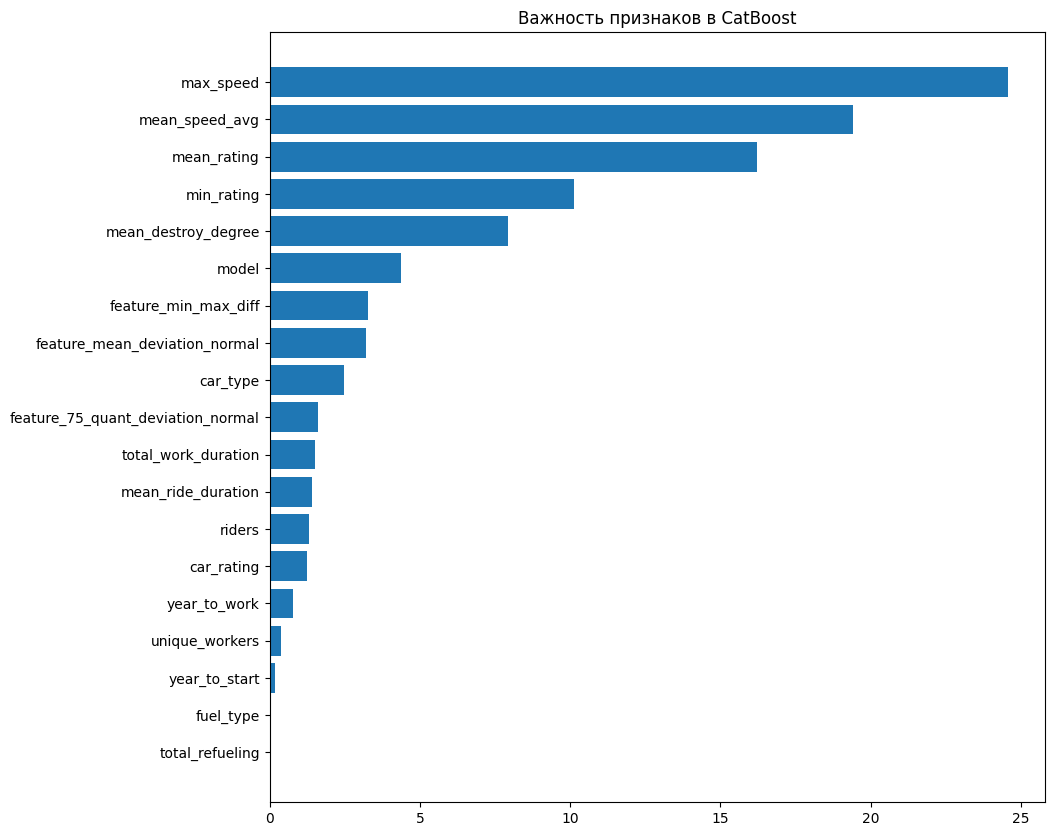

In [56]:
feature_importances = model.get_feature_importance()
sorted_idx = feature_importances.argsort()

plt.figure(figsize=(10, 10))
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [X.columns[i] for i in sorted_idx])
plt.title('Важность признаков в CatBoost')
plt.show()

## 2

In [68]:
import shap

Для Shap переобучил модель с кодировкой

In [77]:
X_encoded = pd.get_dummies(df[cat_features + num_features_corrected], columns=cat_features)

In [78]:
X_train_encoded, X_test_encoded, Y_train, Y_test = train_test_split(X_encoded, Y, test_size=0.2, random_state=42)

model = CatBoostClassifier(verbose=0, random_seed=42)
model.fit(X_train_encoded, Y_train)

In [79]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_encoded)

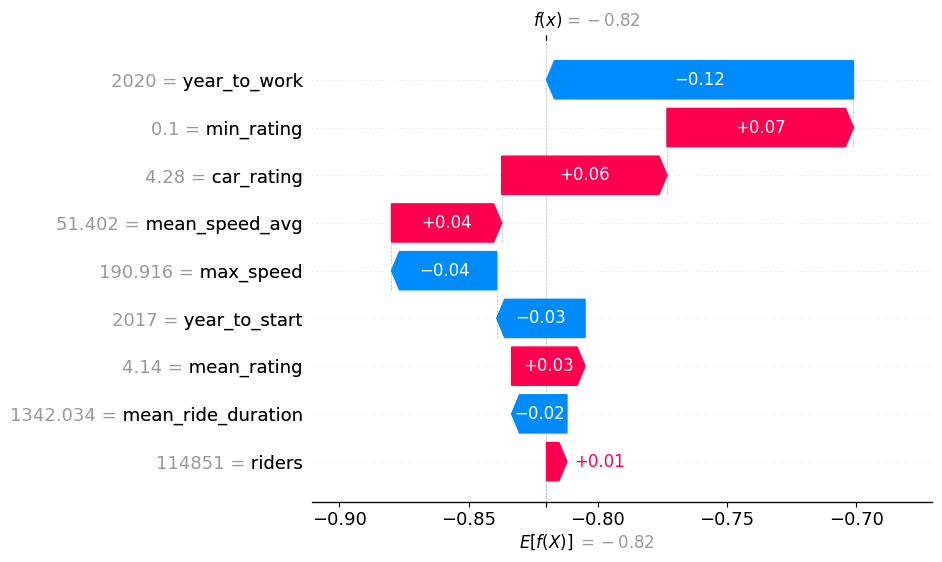

In [80]:
shap.initjs()
shap.waterfall_plot(shap.Explanation(values=shap_values[1][0], 
                                     base_values=explainer.expected_value[1], 
                                     data=X_test_encoded.iloc[0,:], 
                                     feature_names=X_test_encoded.columns.tolist()))

## 3

In [81]:
from sklearn.metrics import classification_report

print(classification_report(Y_test, predictions))

                 precision    recall  f1-score   support

    another_bug       0.95      0.97      0.96        58
      break_bug       1.00      1.00      1.00        56
    electro_bug       1.00      1.00      1.00        51
   engine_check       0.94      0.92      0.93        49
    engine_fuel       0.81      0.60      0.69        58
engine_ignition       0.73      0.83      0.77        58
engine_overheat       0.61      0.71      0.65        48
     gear_stick       0.98      0.96      0.97        51
    wheel_shake       0.90      0.90      0.90        39

       accuracy                           0.87       468
      macro avg       0.88      0.88      0.87       468
   weighted avg       0.88      0.87      0.87       468



### Вывод

**Высокая эффективность**: `another_bug`, `break_bug`, `electro_bug`, и `gear_stick`.

**Средняя эффективность**: Классы `engine_check` и `wheel_shake` - тоже норм результаты, но чуть меньше точностью и полнота.

**Низкая эффективность**:  `engine_fuel`, `engine_ignition`, и `engine_overheat`, особенно `engine_fuel` и `engine_overheat`<br><br>
Но это в сравнениию. В целом результаты можно назвать удовлетворительными

## 4

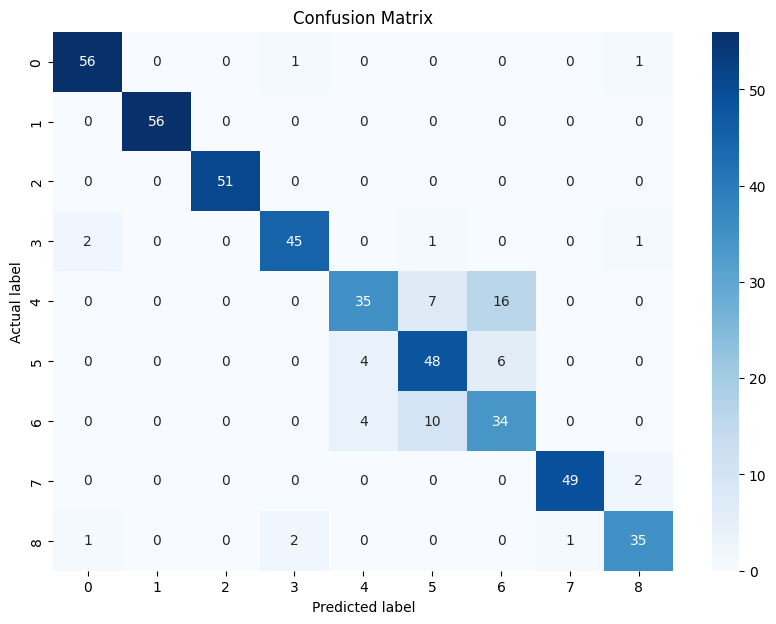

In [83]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(Y_test, predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

Классы с индексами 0, 1, 2, 3, и 8 показывают хорошие результаты с высоким количеством правильных предсказаний (true positives) и низким количеством ошибок (false positives и false negatives), моделб хорошо справляется с идентификацией этих классов.

Класс с индексом 4 (`engine_fuel`) имеет высокое количество false negatives-результатов (23 случая неправильно классифицированы (не как `engine_fuel`)). То есть модель плохо идентифицрует этот класс, когда он присутствует.

Классы с индексами 5 и 6 (`engine_ignition` и `engine_overheat`) также имеют заметное число ошибок как false negatives, так и false positives. Для класса с индексом 5 (`engine_ignition`) модель чаще всего неправильно предсказывает класс с индексом 6, т.к. эти признаки схлжи.

Класс с индексом 7 (`gear_stick`) показывает хорошую точность с небольшим числом ошибок.

# Домашнее задание 3. Оптимизация. Тюнинг гиперпараметров с помощью `Optuna`

<div class="alert alert-info">

**Цель блока** — улучшить качество предсказания, произведя подбор гиперпараметров для модели с помощью `Optuna`.

## Подбор гиперпараметров (3 балла)

1. Напишите `objective` функцию и запустите `Optuna`.
2. Подберите гиперпараметры для `CatBoostClassifier` (минимум 3).
3. Обучите модель с новыми гиперпараметрами, сравните качество и сделайте выводы.

    
<h4> Критерии оценивания </h4>
    
- 1 балл за каждый корректно выполненный пункт.
    
</div>

In [ ]:
# YOUR CODE HERE

### Общая информация по `Optuna`

#### Ключевые особенности <code>Optuna</code>



- Легковесность и универсальность — можно подбирать оптимальные параметры под любые функции и метрики.
- SOTA-алгоритмы, адаптированные для поиска гиперпараметров.
- Параллелизация и различные методы прунинга.
- Встроенная визуализация.
- Интеграция со множеством популярных библиотек (бустинги, sklearn, PyTorch, W&B и другие).

Разберем Optuna по частям, чтобы понять, как ее использовать.

#### <code>Study</code>: оптимизация, базирующаяся на <code>Objective</code> функции



В `Objective`-функцию нужно написать код подсчета метрики, которую возвращаем. `Objective` вызывается Optuna много раз для подбора лучших параметров.
```python
def objective(trial, ...):
    # calculate score...
    return score
```

<h4> <code>Trial</code> — одно выполнение <code>Objective</code>-функции</h4>

В `trial`-объекте мы передаем параметры для «перебора», используя для каждого типа свой метод. Например:

```python
# метод `suggest_float` показывает, что перебираем `float` значения, от 0 и до 1.5 границы
param = trial.suggest_float('param', 0, 1.5)

# Категориальное значение
loss_function = trial.suggest_categorical('loss', ['Logloss', 'CrossEntropy'])

# Целочисленное значение
depth = trial.suggest_int('depth', 5, 8)

# Равномерное распределение
learning_rate = trial.suggest_uniform('learning_rate', 0.0, 1.0)
```

#### `Study` parameters

Инициализируем объект `study`, который начнет перебор и сохранит в себе историю результатов.
Если мы стараемся увеличить метрику, а не уменьшить ошибку, то используем `create_study(direction='maximize')`.
```python
study = optuna.create_study()
study.optimize(objective, n_trials=10)
```

<div class="alert alert-info">
    
В [`Optuna`](https://optuna.readthedocs.io/en/stable/index.html) реализовано несколько методов (`sampler`) подбора параметров (в том числе классические):
* `GridSampler`
* `RandomSampler`
* `Tree-Structed Parzen Estimator` (`TPESampler` — самый популярный, дефолтный)
* `BruteForceSampler`
* [Другие 4 метода](https://optuna.readthedocs.io/en/stable/reference/samplers/index.html#module-optuna.samplers) (можно написать собственный семплер)

### Советы по перебору параметров

- Иметь понимание важности параметров.
- Число `iterations` лучше взять с запасом и зафиксировать, при этом ограничив через `early_stopping_rounds`.
- Подсмотреть или чувствовать диапазоны и шаг значений.
- Исключить то, что перебирать не нужно (`random_seed` , `eval_metric`, `thread_count` и прочее).
- Используйте информацию с прошлых попыток.

# Домашнее задание 4. Блендинг

<div class="alert alert-info">

**Цель блока** — улучшить качество предсказания, объединив несколько моделей вместе методом блендинга.

## Задание 6. Блендинг (10 баллов)

1. Построить и обучить модели:
    - `CatBoostClassifier`,
    - `LightGBMClassifier (goss)`,
    - `XGBoostClassifier (dart)`,
    - `RandomForestClassifier`.
2. Сделать предсказания каждой моделью, оценить качество.
3. Реализовать блендинг двумя способами, оценить качество и сравнить с предыдущим пунктом:
    - `Hard Voting` —  метод, при котором делаем голосование всех моделей и выбираем самый популярный класс.
    - `Soft Voting` —  метод, при котором мы складываем вероятности предсказания всех моделей по каждому классу и потом выбираем самый класс с максимальной суммой.
    
<h4> Критерии оценивания </h4>
    
- Обучены 4 модели — 1 балл за каждую обученную модель, всего 4 балла.
- Для модели проведен подбор гиперпараметров — 0,5 балла за каждый параметр, всего 2 балла.
- Сделаны предсказания каждой модели и оценено качество — 1 балл.
- Реализован `Hard Voting` — 1 балл.
- Реализован `Soft Voting` — 1 балл.
- Сделаны выводы — 1 балл.
    
</div>

In [ ]:
# YOUR CODE HERE

### Общая информация о блендинге

**Основная идея** — взять от каждого алгоритма лучшее и совместить несколько разных ML-моделей в одну.

Что это дает:
- Увеличивается обобщающая способность финальной модели и качество улучшается.
- Модель становится более стабильной, что позволяет не слететь на приватном лидерборде.

Особенно хорошо накидывает блендинг, если смешиваемые модели имеют разную природу — например, нейронные сети, kNN и решающие деревья. Они выучивают разные зависимости и хорошо дополняют друг друга.

</div>

# <center id="part6"> Отправка финального решения на лидерборд на Kaggle

<div class="alert alert-info">

**Цель блока** — сделать предсказание с помощью блендинга для тестовой части датасета, отправить результат [в соревнование на Kaggle](https://www.kaggle.com/competitions/competative-data-science-course-by-data-feeling/overview).

## Задание 8. Предсказание на тестовом датасете и отправка на Kaggle

1. Сделать предобработку для тестового датасета, присоединить к нему информацию из других датасетов и добавить признаки, которые генерировали для тренировочного датасета.
2. Сделать предсказания каждой моделью, которую хотите включить в ансамбль, но минимум их должно быть 3.
3. Сделать блендинг с помощью `Hard Voting` или `Soft Voting` на ваш выбор.
4. Сохранить результат предсказания в `csv` файл и отправить решение на Kaggle.
    
<h4> Критерии оценивания </h4>
    
- 0 баллов за задание, если итоговый скор на лидерборде меньше чем `0.9`.
- 1 балл за каждый выполненный пункт.

</div>

In [ ]:
car_test = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_test.csv')
car_test.head(3)

In [ ]:
# YOUR CODE HERE

### Советы по отправке кода на Kaggle



Если пишете код на `Kaggle`, то для отправки решения:

1. Нажать Save Version.
2. Проверить, что в Advanced Settings выбрано «Всегда сохранять результаты ноутбука».
3. Выбрать тип сохранения Save & Run All (Commit).
4. Нажать кнопку Save.